# Microplastic sample overview
This notebook summarizes how many plastic spectra we have in the reference database and breaks them down by plastic ID.

In [162]:

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

DB_PATH = "app/database/microplastics_reference.db"


## Totals

In [163]:

with sqlite3.connect(DB_PATH) as conn:
    total_rows = pd.read_sql_query("SELECT COUNT(*) AS n FROM microplastics", conn)["n"].iat[0]
    unique_plastics = pd.read_sql_query("SELECT COUNT(DISTINCT ID) AS n FROM microplastics", conn)["n"].iat[0]

print(f"Total spectral rows in microplastics table: {total_rows}")
print(f"Unique plastics (IDs): {unique_plastics}")


Total spectral rows in microplastics table: 539751
Unique plastics (IDs): 339


## Counts by plastic ID

In [164]:

with sqlite3.connect(DB_PATH) as conn:
    counts_df = pd.read_sql_query(
        """
        SELECT ID AS plastic, COUNT(*) AS samples
        FROM microplastics
        GROUP BY ID
        ORDER BY samples DESC, plastic
        """,
        conn,
    )

print(f"Number of plastic types: {len(counts_df)}")
counts_df


Number of plastic types: 339


,plastic,samples
0,ABS PLAS193,3201
1,BPF PLAS233,3201
2,BR PLAS226,3201
3,CA PLAS163,3201
4,EPS PLAS104,3201
...,...,...
334,Polypropylene 18. Purple Foam,727
335,Polypropylene 5. Green Fiber,727
336,Acrylic 2. Pink Fiber Bundle (Polyacrylonitrile),717
337,Cellulose Acetate 2. White Fragment,710


## Top plastics (bar chart)

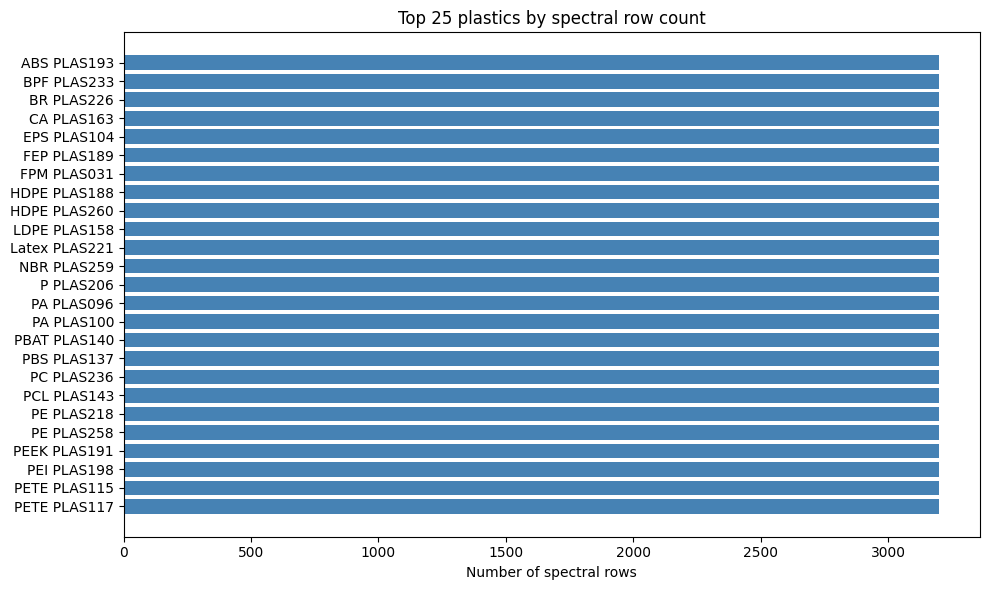

In [165]:

top_n = 25
subset = counts_df.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(subset["plastic"][::-1], subset["samples"][::-1], color="steelblue")
plt.xlabel("Number of spectral rows")
plt.title(f"Top {top_n} plastics by spectral row count")
plt.tight_layout()
plt.show()


## List all plastic IDs (from counts_df)

In [166]:

# Print every plastic ID in the counts table so you can see them all
for name in counts_df["plastic"]:
    print(name)


ABS PLAS193
BPF PLAS233
BR PLAS226
CA PLAS163
EPS PLAS104
FEP PLAS189
FPM PLAS031
HDPE PLAS188
HDPE PLAS260
LDPE PLAS158
Latex PLAS221
NBR PLAS259
P PLAS206
PA PLAS096
PA PLAS100
PBAT PLAS140
PBS PLAS137
PC PLAS236
PCL PLAS143
PE PLAS218
PE PLAS258
PEEK PLAS191
PEI PLAS198
PETE PLAS115
PETE PLAS117
PETE PLAS126
PETE PLAS157
PETG PLAS194
PEX PLAS084
PFA PLAS216
PI PLAS197
PLA PLAS171
PMMA PLAS195
POM PLAS232
PP PLAS055
PP PLAS072
PP PLAS175
PP PLAS223
PPE PLAS051
PPO PLAS199
PPS PLAS213
PS PLAS102
PS PLAS160
PS PLAS187
PSA PLAS176
PTFE PLAS201
PVA PLAS052
PVC PLAS151
PVDF PLAS214
SBS PLAS113
UHMW PLAS032
beachcast white foam sheet PLAS251
blue fragment PLAS253
bone BIOL001
bone BIOL007
bone BIOL009
bone BIOL025
calcium carbonate BIOL003
calcium carbonate BIOL014
cellulose BIOL005
cellulose BIOL021
cellulose PLAS257
charcoal BIOL002
chitin BIOL004
chitin BIOL012
chitin BIOL022
clear plastic hollow sphere PLAS256
collagen BIOL016
dentin BIOL008
drip irrigation tubing PLAS248
green plastic

## Group plastics by base name (strip trailing PLAS codes)

In [167]:

import re


def normalize_base_name(name: str) -> str:
    # Drop trailing PLAS code
    cleaned = re.sub(r"\s*PLAS\d+$", "", name).strip()
    # If there's a number+optional dot after the main name, keep only the name
    parts = re.split(r"\s+\d+(?:\.|\s|$)", cleaned, maxsplit=1)
    return parts[0].strip() if parts else cleaned


# Derive a simplified base name by removing trailing PLAS code and trailing numbering
counts_df["base_name"] = counts_df["plastic"].apply(normalize_base_name)

# Summarize by base name
base_groups = counts_df.groupby("base_name").agg(
    plastic_count=("plastic", "count"),
    spectra_rows=("samples", "sum"),
    ids=("plastic", lambda x: sorted(x)),
)

base_groups = base_groups.sort_values(["spectra_rows", "plastic_count"], ascending=False)
print(f"Distinct base plastic names: {len(base_groups)}")
base_groups.head(30)


Distinct base plastic names: 95


,plastic_count,spectra_rows,ids
base_name,,,
Polyethylene,50,64336,"[Polyethylene 1. Blue Sphere, Polyethylene 10...."
Polypropylene,38,43514,"[Polypropylene 1. Light Blue Fragment, Polypro..."
Polystyrene,20,25611,"[Polystyrene 1. Brown Coffee Cup Lid, Polystyr..."
Polyester,22,18512,"[Polyester 1. Clear Fiber, Polyester 1. White ..."
Polyurethane,12,14946,"[Polyurethane 1. Black Fiber, Polyurethane 11...."
Polyamide,14,14020,"[Polyamide 1. Blue Fragment, Polyamide 1. Whit..."
Polyvinyl Chloride,13,13880,"[Polyvinyl Chloride 10. White Microsphere, Pol..."
PETE,4,12804,"[PETE PLAS115, PETE PLAS117, PETE PLAS126, PET..."
PP,4,12804,"[PP PLAS055, PP PLAS072, PP PLAS175, PP PLAS223]"


## Plot spectra grouped by base plastic name

Plotting group: Polyethylene


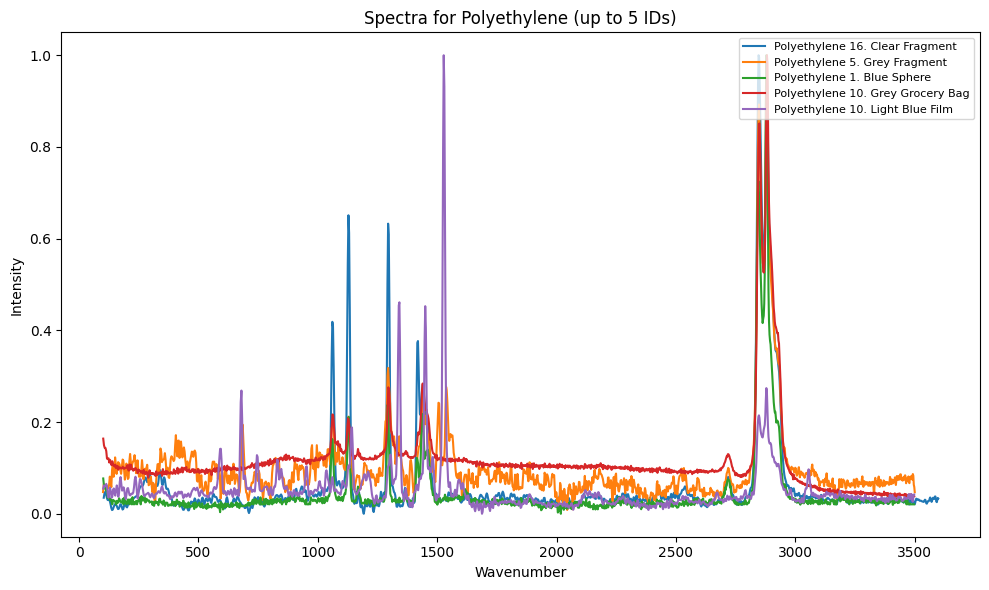

Plotting group: Polypropylene


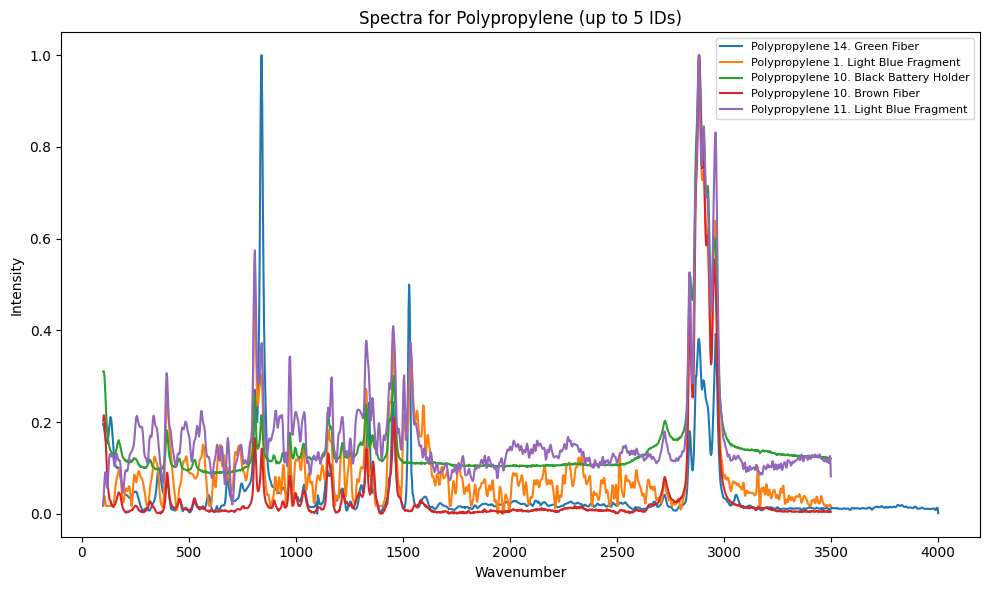

Plotting group: Polystyrene


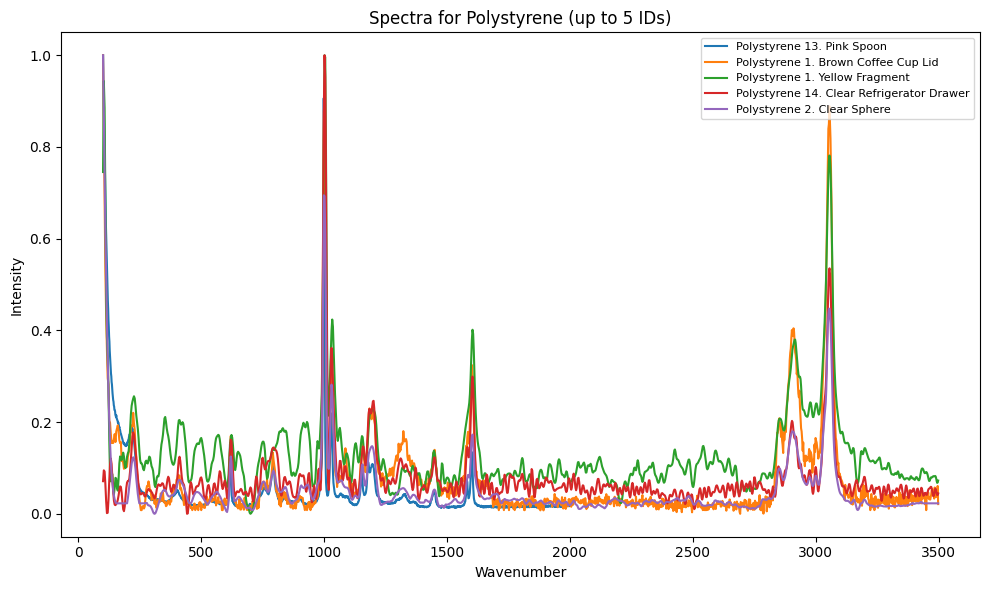

Plotting group: Polyester


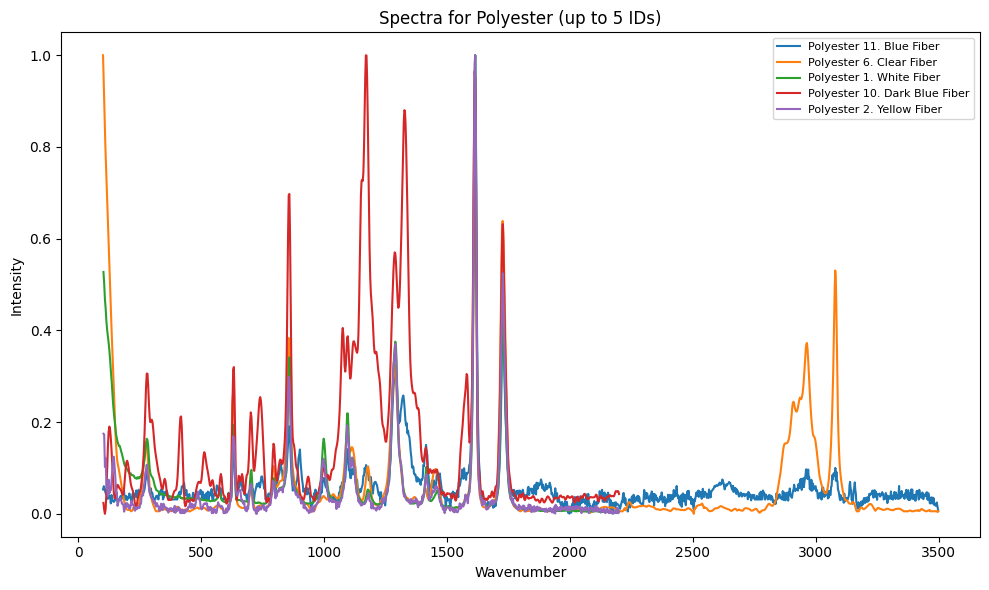

Plotting group: Polyurethane


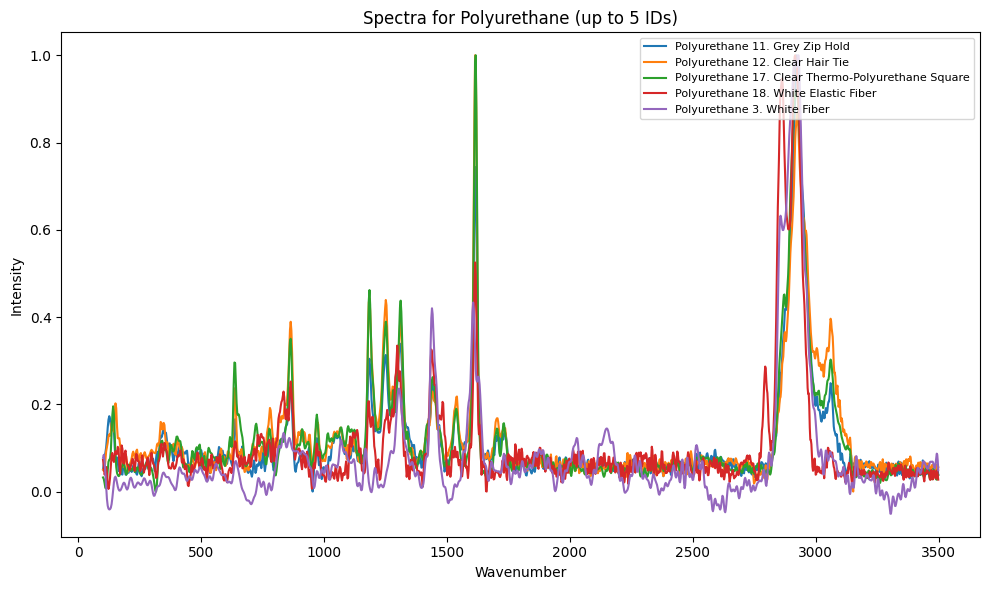

Plotting group: Polyamide


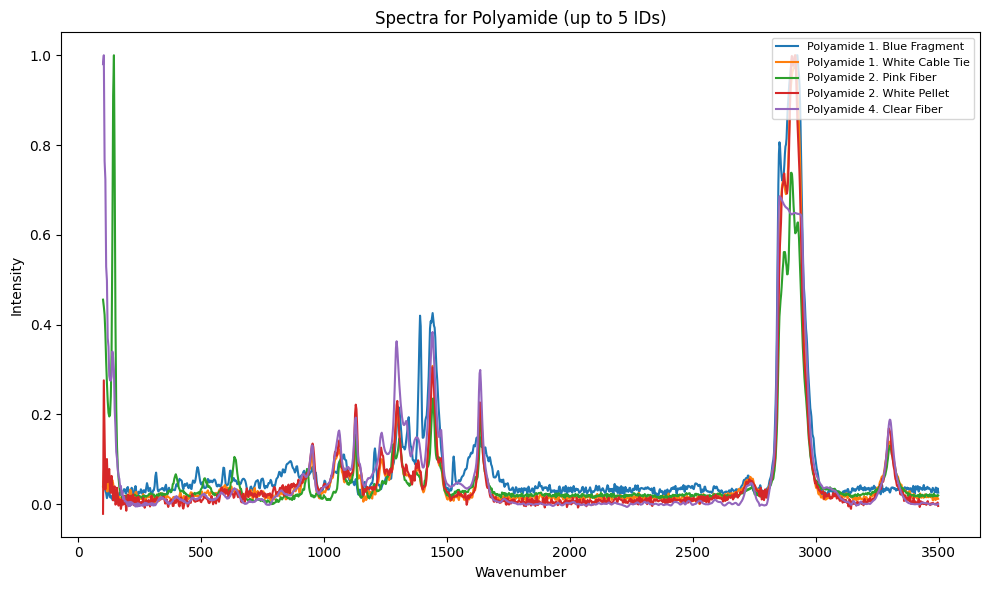

In [168]:

from typing import Iterable


def plot_group(base_name: str, max_ids: int = 5):
    """Plot spectra for IDs that share the given base name."""
    ids = counts_df.loc[counts_df["base_name"] == base_name, "plastic"]
    if ids.empty:
        print(f"No IDs found for base name '{base_name}'.")
        return

    with sqlite3.connect(DB_PATH) as conn:
        plt.figure(figsize=(10, 6))
        for pid in ids.head(max_ids):
            df = pd.read_sql_query(
                "SELECT WaveNumber, Intensity FROM microplastics WHERE ID=?",
                conn,
                params=(pid,),
            ).sort_values("WaveNumber")
            plt.plot(df["WaveNumber"], df["Intensity"], label=pid)

    plt.title(f"Spectra for {base_name} (up to {max_ids} IDs)")
    plt.xlabel("Wavenumber")
    plt.ylabel("Intensity")
    plt.legend(loc="upper right", fontsize=8)
    plt.tight_layout()
    plt.show()


# Example: automatically plot the first 6 grouped names
example_groups = list(base_groups.index[:6])
for name in example_groups:
    print(f"Plotting group: {name}")
    plot_group(name, max_ids=5)


## Clustering-style scatter plots by plastic group

In [169]:

import numpy as np

# Aggregate per-plastic features directly from the DB
with sqlite3.connect(DB_PATH) as conn:
    features_df = pd.read_sql_query(
        """
        SELECT
            ID AS plastic,
            COUNT(*) AS n_points,
            AVG(Intensity) AS mean_intensity,
            AVG(Intensity * Intensity) AS mean_sq_intensity,
            MIN(WaveNumber) AS min_wn,
            MAX(WaveNumber) AS max_wn
        FROM microplastics
        GROUP BY ID
        """,
        conn,
    )

features_df["std_intensity"] = np.sqrt(
    np.clip(
        features_df["mean_sq_intensity"] - features_df["mean_intensity"] ** 2,
        a_min=0,
        a_max=None,
    )
)
features_df["wn_span"] = features_df["max_wn"] - features_df["min_wn"]
features_df["log_points"] = np.log10(features_df["n_points"])

# Reuse the same grouping logic used earlier
features_df["base_name"] = features_df["plastic"].apply(normalize_base_name)
features_df.head()


,plastic,n_points,mean_intensity,mean_sq_intensity,min_wn,max_wn,std_intensity,wn_span,log_points,base_name
0,ABS PLAS193,3201,0.141709,0.039891,200.000,3400.00,0.140746,3200.000,3.505286,ABS
1,Acrylic 1. Green Yarn,839,0.129432,0.040250,102.528,2199.96,0.153287,2097.432,2.923762,Acrylic
2,Acrylic 1. Red Fiber (Polyacrylonitrile),743,0.274102,0.111155,102.366,1998.32,0.189798,1895.954,2.870989,Acrylic
3,Acrylic 10. Pink Fiber,743,0.201341,0.066893,102.528,1998.48,0.162340,1895.952,2.870989,Acrylic
4,Acrylic 2. Pink Fiber Bundle (Polyacrylonitrile),717,0.450009,0.231812,180.809,1998.48,0.171183,1817.671,2.855519,Acrylic


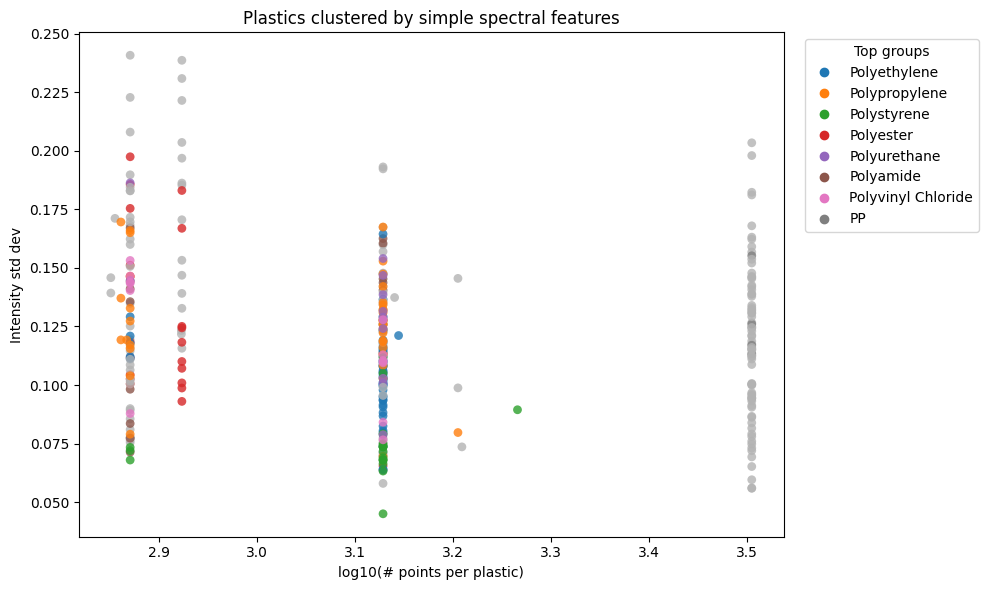

In [170]:

# Color only the largest groups; everything else is gray
by_group = features_df.groupby("base_name")["n_points"].sum().sort_values(ascending=False)
top_groups = list(by_group.head(8).index)

cmap = plt.get_cmap("tab10")
color_map = {g: cmap(i % 10) for i, g in enumerate(top_groups)}

colors = [color_map.get(g, (0.7, 0.7, 0.7, 0.5)) for g in features_df["base_name"]]

plt.figure(figsize=(10, 6))
plt.scatter(
    features_df["log_points"],
    features_df["std_intensity"],
    c=colors,
    s=40,
    alpha=0.8,
    edgecolors="none",
)
plt.xlabel("log10(# points per plastic)")
plt.ylabel("Intensity std dev")
plt.title("Plastics clustered by simple spectral features")

# Legend for top groups only
handles = [
    plt.Line2D([0], [0], marker='o', linestyle='', color=color_map[g], label=g)
    for g in top_groups
]
plt.legend(handles=handles, title="Top groups", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


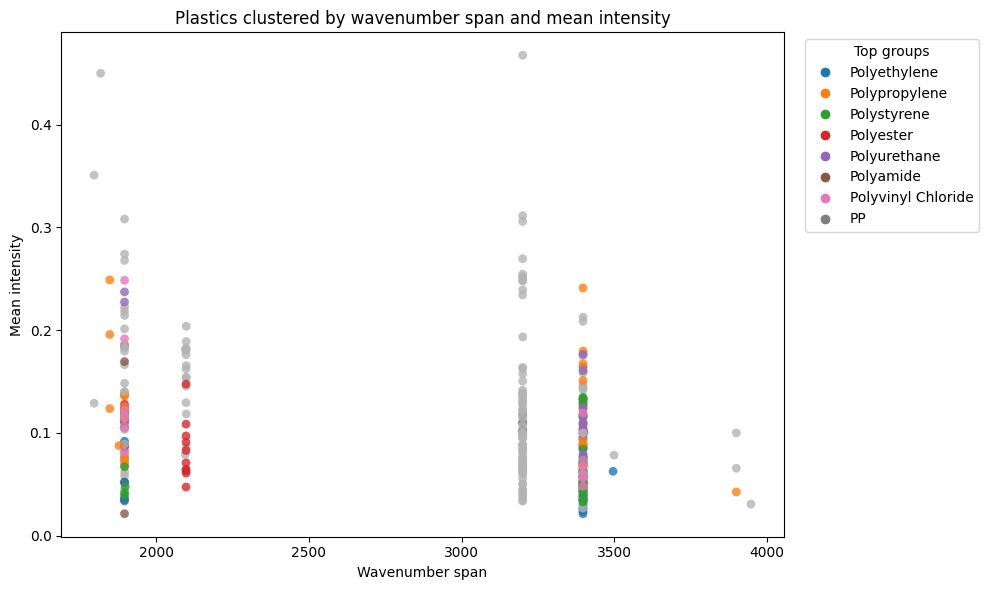

In [171]:

# Alternate view: wavenumber span vs mean intensity
colors = [color_map.get(g, (0.7, 0.7, 0.7, 0.5)) for g in features_df["base_name"]]

plt.figure(figsize=(10, 6))
plt.scatter(
    features_df["wn_span"],
    features_df["mean_intensity"],
    c=colors,
    s=40,
    alpha=0.8,
    edgecolors="none",
)
plt.xlabel("Wavenumber span")
plt.ylabel("Mean intensity")
plt.title("Plastics clustered by wavenumber span and mean intensity")

handles = [
    plt.Line2D([0], [0], marker='o', linestyle='', color=color_map[g], label=g)
    for g in top_groups
]
plt.legend(handles=handles, title="Top groups", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


## Chemically meaningful band features (peak/region based)

In [172]:

# Define chemically meaningful Raman bands (cm^-1)
bands = {
    "skeletal_800_1200": (800, 1200),
    "ch_bend_1300_1500": (1300, 1500),
    "aromatic_1580_1700": (1580, 1700),
    "ch_stretch_2800_3100": (2800, 3100),
}

# Aggregate band areas per plastic ID directly in SQL
select_parts = ["ID AS plastic", "SUM(Intensity) AS total_intensity", "COUNT(*) AS n_points"]
for name, (lo, hi) in bands.items():
    select_parts.append(
        f"SUM(CASE WHEN WaveNumber BETWEEN {lo} AND {hi} THEN Intensity ELSE 0 END) AS {name}"
    )

query = "SELECT " + ", ".join(select_parts) + " FROM microplastics GROUP BY ID"

with sqlite3.connect(DB_PATH) as conn:
    band_df = pd.read_sql_query(query, conn)

# Normalize band areas by total intensity to reduce scale effects
for name in bands:
    band_df[f"{name}_frac"] = band_df[name] / band_df["total_intensity"].clip(lower=1e-9)

# Ratios capture chemical signatures (robust to absolute scaling)
band_df["ratio_aromatic_to_ch"] = (
    band_df["aromatic_1580_1700"] / band_df["ch_stretch_2800_3100"].clip(lower=1e-9)
)
band_df["ratio_skeletal_to_chbend"] = (
    band_df["skeletal_800_1200"] / band_df["ch_bend_1300_1500"].clip(lower=1e-9)
)

band_df["base_name"] = band_df["plastic"].apply(normalize_base_name)
band_df.head()


,plastic,total_intensity,n_points,skeletal_800_1200,ch_bend_1300_1500,aromatic_1580_1700,ch_stretch_2800_3100,skeletal_800_1200_frac,ch_bend_1300_1500_frac,aromatic_1580_1700_frac,ch_stretch_2800_3100_frac,ratio_aromatic_to_ch,ratio_skeletal_to_chbend,base_name
0,ABS PLAS193,453.610668,3201,77.523057,26.537546,26.901652,124.359117,0.170902,0.058503,0.059306,0.274154,2.163223e-01,2.921259,ABS
1,Acrylic 1. Green Yarn,108.593392,839,31.218650,20.447442,7.875957,0.000000,0.287482,0.188294,0.072527,0.000000,7.875957e+09,1.526775,Acrylic
2,Acrylic 1. Red Fiber (Polyacrylonitrile),203.658122,743,43.775633,34.963155,8.601797,0.000000,0.214947,0.171676,0.042236,0.000000,8.601797e+09,1.252050,Acrylic
3,Acrylic 10. Pink Fiber,149.596416,743,37.722361,26.824183,4.564866,0.000000,0.252161,0.179310,0.030515,0.000000,4.564866e+09,1.406282,Acrylic
4,Acrylic 2. Pink Fiber Bundle (Polyacrylonitrile),322.656764,717,72.197514,48.940070,18.722483,0.000000,0.223759,0.151678,0.058026,0.000000,1.872248e+10,1.475223,Acrylic


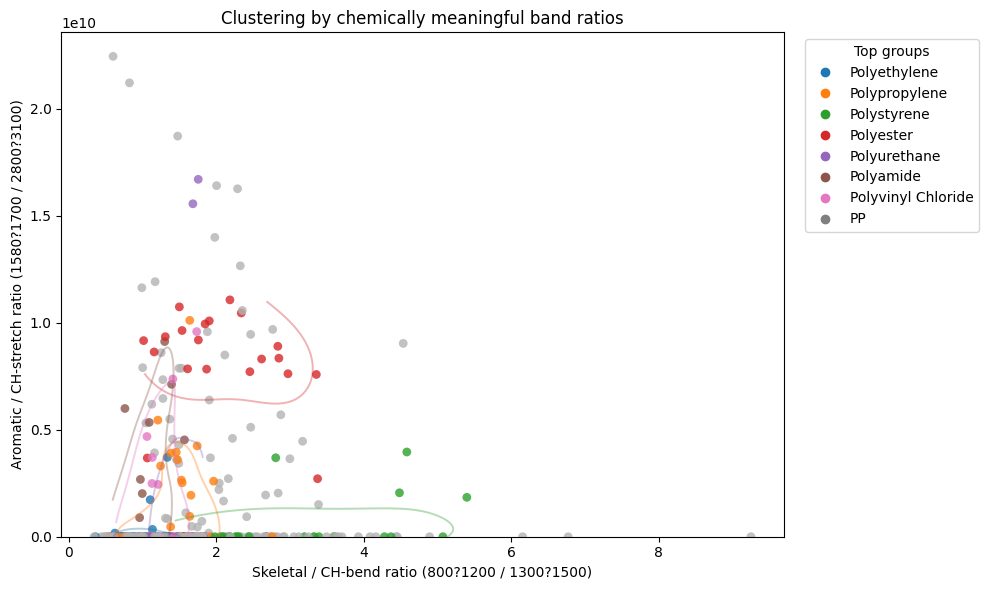

In [173]:

import numpy as np
from scipy.stats import gaussian_kde

plt.figure(figsize=(10, 6))
plt.scatter(
    band_df["ratio_skeletal_to_chbend"],
    band_df["ratio_aromatic_to_ch"],
    c=colors,
    s=40,
    alpha=0.8,
    edgecolors="none",
)
plt.xlabel("Skeletal / CH-bend ratio (800?1200 / 1300?1500)")
plt.ylabel("Aromatic / CH-stretch ratio (1580?1700 / 2800?3100)")
plt.title("Clustering by chemically meaningful band ratios")

# Draw smooth density outlines for top groups, excluding zero-valued samples
for g in top_groups:
    mask = band_df["base_name"] == g
    x = band_df.loc[mask, "ratio_skeletal_to_chbend"]
    y = band_df.loc[mask, "ratio_aromatic_to_ch"]
    mask_nz = (x > 0) & (y > 0)
    pts = band_df.loc[mask & mask_nz, ["ratio_skeletal_to_chbend", "ratio_aromatic_to_ch"]].dropna().values
    if pts.shape[0] < 5:
        continue
    try:
        kde = gaussian_kde(pts.T)
        dens = kde(pts.T)
        level = float(np.quantile(dens, 0.2))  # ignore sparse outliers
        xmin, xmax = np.percentile(pts[:, 0], [1, 99])
        ymin, ymax = np.percentile(pts[:, 1], [1, 99])
        xx, yy = np.meshgrid(
            np.linspace(xmin, xmax, 120),
            np.linspace(ymin, ymax, 120),
        )
        zz = kde(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)
        plt.contour(xx, yy, zz, levels=[level], colors=[color_map[g]], linewidths=1.4, alpha=0.35)
    except Exception:
        continue

handles = [
    plt.Line2D([0], [0], marker='o', linestyle='', color=color_map[g], label=g)
    for g in top_groups
]
plt.legend(handles=handles, title="Top groups", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


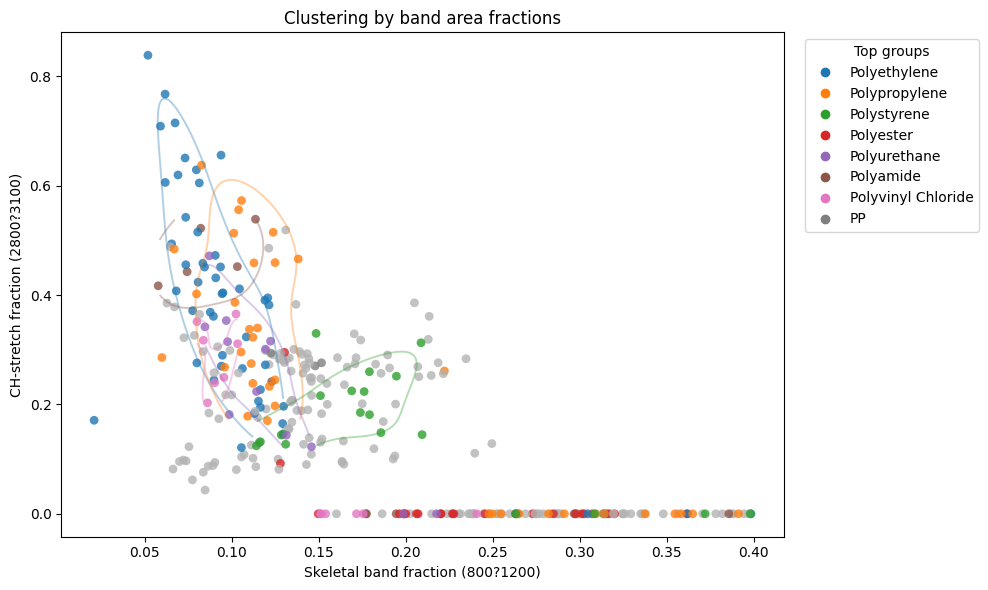

In [174]:

import numpy as np
from scipy.stats import gaussian_kde

plt.figure(figsize=(10, 6))
plt.scatter(
    band_df["skeletal_800_1200_frac"],
    band_df["ch_stretch_2800_3100_frac"],
    c=colors,
    s=40,
    alpha=0.8,
    edgecolors="none",
)
plt.xlabel("Skeletal band fraction (800?1200)")
plt.ylabel("CH-stretch fraction (2800?3100)")
plt.title("Clustering by band area fractions")

# Draw smooth density outlines for top groups, excluding zero-valued samples
for g in top_groups:
    mask = band_df["base_name"] == g
    x = band_df.loc[mask, "skeletal_800_1200_frac"]
    y = band_df.loc[mask, "ch_stretch_2800_3100_frac"]
    mask_nz = (x > 0) & (y > 0)
    pts = band_df.loc[mask & mask_nz, ["skeletal_800_1200_frac", "ch_stretch_2800_3100_frac"]].dropna().values
    if pts.shape[0] < 5:
        continue
    try:
        kde = gaussian_kde(pts.T)
        dens = kde(pts.T)
        level = float(np.quantile(dens, 0.2))  # ignore sparse outliers
        xmin, xmax = np.percentile(pts[:, 0], [1, 99])
        ymin, ymax = np.percentile(pts[:, 1], [1, 99])
        xx, yy = np.meshgrid(
            np.linspace(xmin, xmax, 120),
            np.linspace(ymin, ymax, 120),
        )
        zz = kde(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)
        plt.contour(xx, yy, zz, levels=[level], colors=[color_map[g]], linewidths=1.4, alpha=0.35)
    except Exception:
        continue

handles = [
    plt.Line2D([0], [0], marker='o', linestyle='', color=color_map[g], label=g)
    for g in top_groups
]
plt.legend(handles=handles, title="Top groups", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


## Build an ideal (consensus) spectrum for a group

In [175]:

from scipy.signal import savgol_filter, find_peaks


def build_consensus_spectrum(group_name, max_ids=30, grid_step=2.0, trim_pct=10):
    # Collect spectra for all IDs in a group
    ids = counts_df.loc[counts_df["base_name"] == group_name, "plastic"].tolist()
    if not ids:
        raise ValueError(f"No IDs found for group '{group_name}'.")

    # Limit number of IDs to keep runtime reasonable
    ids = ids[:max_ids]

    spectra = []
    min_wn = None
    max_wn = None
    for sid in ids:
        intensities, wns, _ = utils.get_spectrum_data(sid, DB_PATH)
        if not intensities:
            continue
        wn = np.asarray(wns, dtype=float)
        it = np.asarray(intensities, dtype=float)

        order = np.argsort(wn)
        wn = wn[order]
        it = it[order]

        # normalize per spectrum
        it = it / max(it.max(), 1e-6)

        if min_wn is None:
            min_wn = wn.min()
            max_wn = wn.max()
        else:
            min_wn = max(min_wn, wn.min())
            max_wn = min(max_wn, wn.max())

        spectra.append((wn, it))

    if not spectra or min_wn is None or max_wn is None or min_wn >= max_wn:
        raise ValueError("Not enough overlapping spectra to build consensus.")

    # Shared grid across all spectra (intersection range)
    grid = np.arange(min_wn, max_wn + grid_step, grid_step)
    interp = []
    for wn, it in spectra:
        interp.append(np.interp(grid, wn, it))

    mat = np.vstack(interp)

    # Trim outliers at each wavenumber (robust to odd peaks)
    lo = np.percentile(mat, trim_pct, axis=0)
    hi = np.percentile(mat, 100 - trim_pct, axis=0)
    mat_trim = np.clip(mat, lo, hi)

    # Median as consensus (robust to noise/outliers)
    consensus = np.median(mat_trim, axis=0)

    # Light smoothing to reduce noise
    if len(consensus) >= 11:
        consensus = savgol_filter(consensus, 11, 3)

    return grid, consensus, ids


In [176]:
%matplotlib inline

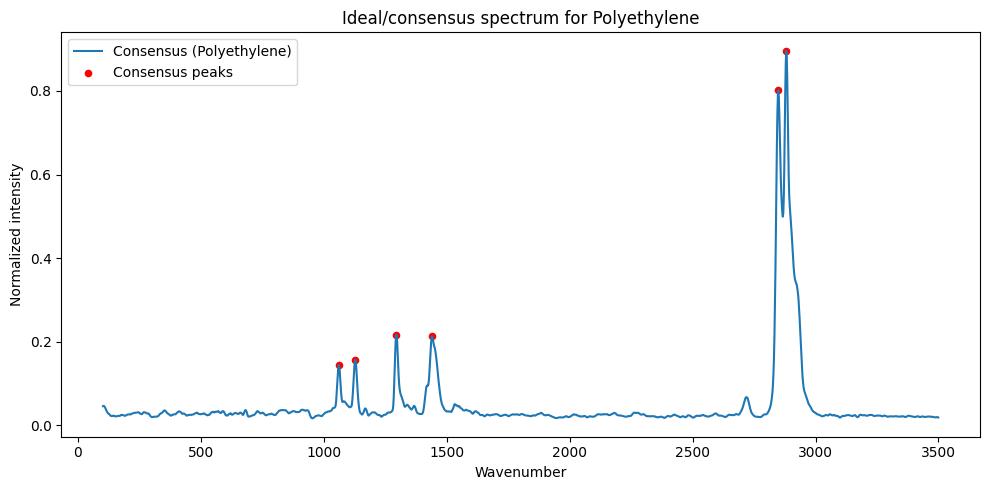

Used 30 IDs for group: Polyethylene


In [177]:

# Example: build and plot an ideal spectrum for a chosen group
example_group = "Polyethylene"

wn_grid, consensus, ids_used = build_consensus_spectrum(example_group, max_ids=30, grid_step=2.0, trim_pct=10)

# Find consensus peaks
peaks, props = find_peaks(consensus, prominence=0.05)

plt.figure(figsize=(10, 5))
plt.plot(wn_grid, consensus, label=f"Consensus ({example_group})")
plt.scatter(wn_grid[peaks], consensus[peaks], color="red", s=20, label="Consensus peaks")
plt.xlabel("Wavenumber")
plt.ylabel("Normalized intensity")
plt.title(f"Ideal/consensus spectrum for {example_group}")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Used {len(ids_used)} IDs for group: {example_group}")
